# Thalassemia Classification - ML Implementation

## Objectives
* Implement advanced ML techniques for improved performance
* Address class imbalance with SMOTE
* Optimize hyperparameters with GridSearchCV
* Add feature scaling and ensemble methods
* Include SHAP for model interpretability
* Optimize prediction threshold for clinical use

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/nour/Desktop/thalassemia_predictor_v2


In [2]:
# Enhanced imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 1: Load Engineered Data

In [3]:
# Load engineered features

X_train = pd.read_csv('outputs/datasets/enhanced/X_train_enhanced.csv')
X_test = pd.read_csv('outputs/datasets/enhanced/X_test_enhanced.csv')
y_train = pd.read_csv('outputs/datasets/enhanced/y_train_enhanced.csv').squeeze()
y_test = pd.read_csv('outputs/datasets/enhanced/y_test_enhanced.csv').squeeze()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features: {list(X_train.columns)}")
print(f"Class distribution: {y_train.value_counts()}")

Training set: (162, 12)
Test set: (41, 12)
Features: ['hba2', 'mentzer_index', 'mcv', 'thal_prob_score', 'hypochromia', 'morphology_score', 'hba2_hbf_ratio', 'anemia_severity_encoded', 'hba', 'mch', 'rbc_hb_ratio', 'rbc']
Class distribution: phenotype
alpha carrier    118
normal            44
Name: count, dtype: int64


## Step 2: Feature Scaling

In [13]:
# Apply feature scaling to numerical features
numerical_features = ['hba2', 'hbf', 'mcv', 'mentzer_index', 'rbc_hb_ratio']
available_numerical = [f for f in numerical_features if f in X_train.columns]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if available_numerical:
    X_train_scaled[available_numerical] = scaler.fit_transform(X_train[available_numerical])
    X_test_scaled[available_numerical] = scaler.transform(X_test[available_numerical])
    print(f"Scaled features: {available_numerical}")
else:
    print("No numerical features found for scaling")

print(f"Scaled training set shape: {X_train_scaled.shape}")

Scaled features: ['hba2', 'mcv', 'mentzer_index', 'rbc_hb_ratio']
Scaled training set shape: (162, 12)


## Step 3: Handle Class Imbalance with SMOTE

In [14]:
# Encode labels for SMOTE
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
print(f"Original class distribution: {np.bincount(y_train_encoded)}")

# Apply SMOTE
smote = SMOTE(random_state=8, k_neighbors=3)  # Reduced k_neighbors for small dataset
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_encoded)

print(f"Balanced training set: {X_train_balanced.shape}")
print(f"Balanced class distribution: {np.bincount(y_train_balanced)}")

Label mapping: {'alpha carrier': np.int64(0), 'normal': np.int64(1)}
Original class distribution: [118  44]
Balanced training set: (236, 12)
Balanced class distribution: [118 118]


## Step 4: Hyperparameter Optimization

In [15]:
X_train_balanced

,hba2,mentzer_index,mcv,thal_prob_score,hypochromia,morphology_score,hba2_hbf_ratio,anemia_severity_encoded,hba,mch,rbc_hb_ratio,rbc
0,0.329764,0.150956,0.847601,1,0,0,4.200000,2,84.864586,28.400000,-1.086491,5.290000
1,1.583407,-0.416827,-1.014699,4,1,2,7.750000,1,87.500000,20.700000,0.870996,4.780000
2,0.391419,-0.584537,-0.695133,7,1,3,2.454545,0,86.400000,21.300000,0.664840,5.210000
3,0.329764,0.774773,1.442656,0,0,0,4.200000,2,84.864586,28.100000,-1.047885,4.970000
4,0.059473,0.785452,1.288382,0,0,0,2.978044,2,86.523291,28.500000,-1.068557,4.880000
...,...,...,...,...,...,...,...,...,...,...,...,...
231,-0.121466,0.262524,0.731935,3,1,1,7.362814,2,86.936734,26.327889,-0.689124,5.117282
232,-1.067920,0.113312,-0.891531,4,1,2,6.869193,0,87.228958,21.239242,0.574679,4.334100
233,0.689416,-0.970470,-0.883537,7,1,3,9.333333,0,85.515322,20.207661,1.064543,5.639213
234,0.254590,-0.931220,-1.073275,7,1,3,1.888383,0,85.807137,21.156145,0.737007,5.441935


In [16]:
# XGBoost hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [300, 500, 1000, 2000],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 10]
}

# print("Starting XGBoost hyperparameter optimization...")
# xgb_grid = GridSearchCV(
#     xgb.XGBClassifier(random_state=4, eval_metric='logloss', objective= "binary:logistic"),
#     xgb_param_grid,
#     cv=3,  # Reduced for faster execution
#     scoring='f1_weighted',
#     n_jobs=-2,
#     verbose=1
# )
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_grid = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=4, eval_metric='logloss', objective="binary:logistic"),
    param_distributions=xgb_param_grid,
    n_iter=12,  # number of parameter sets to try
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_grid.fit(X_train_balanced, y_train_balanced)
best_xgb = xgb_grid.best_estimator_

print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best XGBoost parameters: {'subsample': 0.8, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best CV score: 0.720


## Step 5: Ensemble Methods

In [17]:
# Train individual models first
# rf_model = RandomForestClassifier(n_estimators=600, random_state=4, class_weight='balanced')
# gb_model = GradientBoostingClassifier(n_estimators=600, random_state=4)

rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=1000, max_depth=None, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.05, max_depth=None, random_state=42)

print("Training individual models...")
rf_model.fit(X_train_balanced, y_train_balanced)
gb_model.fit(X_train_balanced, y_train_balanced)


ensemble = VotingClassifier([
    ('xgb', best_xgb),
    ('rf', rf_model),
    ('gb', gb_model)
], voting='soft', weights=[3, 1, 1])

print("Training ensemble model...")
ensemble.fit(X_train_balanced, y_train_balanced)

# Evaluate ensemble
ensemble_pred = ensemble.predict(X_test_scaled)
ensemble_f1 = f1_score(y_test_encoded, ensemble_pred, average='weighted')
print(f"Ensemble F1-Score: {ensemble_f1:.3f}")

Training individual models...
Training ensemble model...
Ensemble F1-Score: 0.728


## Step 6: Threshold Optimization

In [18]:
# Optimize prediction threshold
y_proba = best_xgb.predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_encoded, y_proba)

# Calculate F1 scores for different thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Optimal F1-score: {f1_scores[optimal_idx]:.3f}")

# Apply optimal threshold
y_pred_optimized = (y_proba >= optimal_threshold).astype(int)
optimized_f1 = f1_score(y_test_encoded, y_pred_optimized, average='weighted')
print(f"Optimized F1-Score: {optimized_f1:.3f}")


Optimal threshold: 0.738
Optimal F1-score: 0.556
Optimized F1-Score: 0.789


## Step 7: Model Interpretability with SHAP

Generating SHAP explanations...


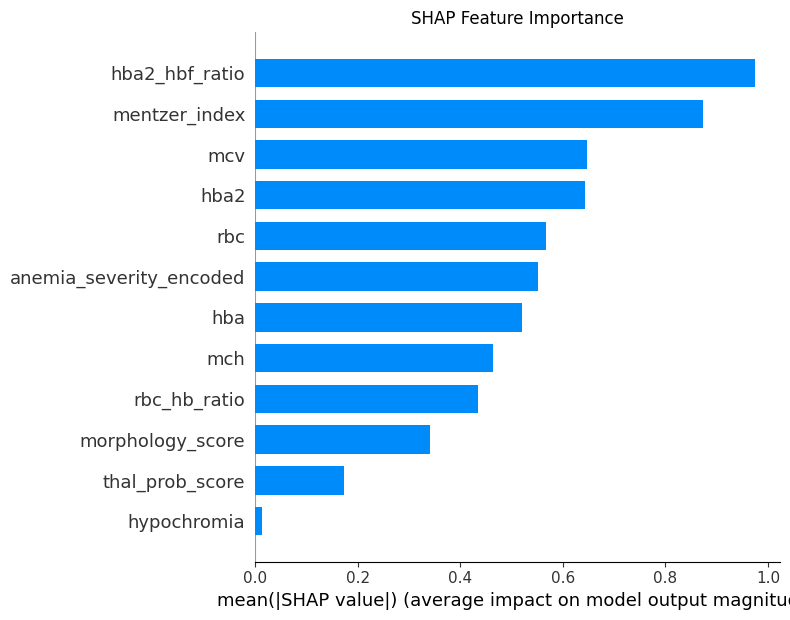

SHAP analysis completed!


In [19]:
# SHAP analysis
print("Generating SHAP explanations...")
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.savefig('outputs/ml_pipeline/predict_thalassemia/v2_improved/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP analysis completed!")

## Step 8: Comprehensive Model Evaluation

In [20]:
# Compare all models
models = {
    'XGBoost (Optimized)': best_xgb,
    'Ensemble': ensemble,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

results = []
for name, model in models.items():
    if name == 'XGBoost (Optimized)':
        pred = y_pred_optimized
    else:
        pred = model.predict(X_test_scaled)
    
    f1_weighted = f1_score(y_test_encoded, pred, average='weighted')
    f1_macro = f1_score(y_test_encoded, pred, average='macro')
    
    results.append({
        'Model': name,
        'F1_Weighted': f1_weighted,
        'F1_Macro': f1_macro
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1_Weighted', ascending=False)
print("\nModel Performance Comparison:")
print(results_df.round(3))

best_model_name = results_df.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")


Model Performance Comparison:
                 Model  F1_Weighted  F1_Macro
0  XGBoost (Optimized)        0.789     0.715
2        Random Forest        0.748     0.669
1             Ensemble        0.728     0.648
3    Gradient Boosting        0.659     0.565

Best Model: XGBoost (Optimized)


## Step 9: Save Enhanced Models

In [22]:
# Create enhanced model directory
import os
enhanced_model_dir = 'outputs/ml_pipeline/predict_thalassemia/v5_enhanced'
os.makedirs(enhanced_model_dir, exist_ok=True)

# Save all components
joblib.dump(best_xgb, f'{enhanced_model_dir}/best_xgb_model.pkl')
joblib.dump(ensemble, f'{enhanced_model_dir}/ensemble_model.pkl')
joblib.dump(scaler, f'{enhanced_model_dir}/feature_scaler.pkl')
joblib.dump(label_encoder, f'{enhanced_model_dir}/label_encoder.pkl')

# Save optimal threshold
import json
model_config = {
    'optimal_threshold': float(optimal_threshold),
    'best_model': best_model_name,
    'best_f1_score': float(results_df.iloc[0]['F1_Weighted']),
    'features': list(X_train.columns)
}

with open(f'{enhanced_model_dir}/model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

# Save performance results
results_df.to_csv(f'{enhanced_model_dir}/model_comparison.csv', index=False)

print(f"Enhanced models saved to: {enhanced_model_dir}")
print(f"Best F1-Score achieved: {results_df.iloc[0]['F1_Weighted']:.3f}")

Enhanced models saved to: outputs/ml_pipeline/predict_thalassemia/v5_enhanced
Best F1-Score achieved: 0.789
